The ECMWF Tropical cyclone data are in grib format using 2 different formats, name a regular_gg (lat/lon) grid and the so called reduced_gg grid. A desciption of this grid can be seen here https://software.ecmwf.int/wiki/display/EMOS/Reduced+Gaussian+Grids. Note that the latter grid type is not in a regular format. In fact for every latitude there is a number of longitudes so that local east-west grid length remains approximately constant for all latitudes.

The pygrib module can read the files like this and more importantly can also 'expand' them in regular lat,lon grids.

In [11]:
%matplotlib notebook

In [1]:
infile='/mnt/ECMWF/grib/2016/06/18/20160618.00.tropical_cyclone.grib'


In [8]:
import pygrib

data=pygrib.open(infile)

and then get the variables we need as messages of 'data'

In [9]:
for g in data:
    print g

1:Mean sea level pressure:Pa (instant):reduced_gg:surface:level 0:fcst time 0 hrs:from 201606180000
2:10 metre U wind component:m s**-1 (instant):reduced_gg:surface:level 0:fcst time 0 hrs:from 201606180000
3:10 metre V wind component:m s**-1 (instant):reduced_gg:surface:level 0:fcst time 0 hrs:from 201606180000
4:Mean sea level pressure:Pa (instant):reduced_gg:surface:level 0:fcst time 1 hrs:from 201606180000
5:10 metre U wind component:m s**-1 (instant):reduced_gg:surface:level 0:fcst time 1 hrs:from 201606180000
6:10 metre V wind component:m s**-1 (instant):reduced_gg:surface:level 0:fcst time 1 hrs:from 201606180000
7:Mean sea level pressure:Pa (instant):reduced_gg:surface:level 0:fcst time 2 hrs:from 201606180000
8:10 metre U wind component:m s**-1 (instant):reduced_gg:surface:level 0:fcst time 2 hrs:from 201606180000
9:10 metre V wind component:m s**-1 (instant):reduced_gg:surface:level 0:fcst time 2 hrs:from 201606180000
10:Mean sea level pressure:Pa (instant):reduced_gg:surface

In [10]:
slp=data[1]
u10=data[2]
v10=data[3]

We can see the attributes of the data as

In [11]:
slp.keys()

[u'parametersVersion',
 u'UseEcmfConventions',
 u'GRIBEX_boustrophedonic',
 u'hundred',
 u'globalDomain',
 u'GRIBEditionNumber',
 u'eps',
 u'offsetSection0',
 u'section0Length',
 u'totalLength',
 u'editionNumber',
 u'WMO',
 u'productionStatusOfProcessedData',
 u'section1Length',
 u'wrongPadding',
 u'table2Version',
 u'centre',
 u'centreDescription',
 u'generatingProcessIdentifier',
 u'gridDefinition',
 u'indicatorOfParameter',
 u'parameterName',
 u'parameterUnits',
 u'indicatorOfTypeOfLevel',
 u'pressureUnits',
 u'typeOfLevelECMF',
 u'typeOfLevel',
 u'level',
 u'yearOfCentury',
 u'month',
 u'day',
 u'hour',
 u'minute',
 u'second',
 u'unitOfTimeRange',
 u'P1',
 u'P2',
 u'timeRangeIndicator',
 u'numberIncludedInAverage',
 u'numberMissingFromAveragesOrAccumulations',
 u'centuryOfReferenceTimeOfData',
 u'subCentre',
 u'paramIdECMF',
 u'paramId',
 u'cfNameECMF',
 u'cfName',
 u'cfVarNameECMF',
 u'cfVarName',
 u'unitsECMF',
 u'units',
 u'nameECMF',
 u'name',
 u'decimalScaleFactor',
 u'setLoca

In [12]:
lat,lon=slp['latitudes'],slp['longitudes']

In [13]:
lat.shape, lon.shape

((6599680,), (6599680,))

The number of lat locations are 

In [14]:
slp['distinctLatitudes'].shape

(2560,)

We can see whay type of grid we have by printing the corresponding variable

In [15]:
slp['gridType']

u'reduced_gg'

If the grid is reduce_gg the number of lon points per lat are given as array by

In [16]:
if slp['gridType'] == 'reduced_gg' :
  slp['pl']
  print slp['pl'].shape

(2560,)


we can see the reduce_gg grid by ploting it on the globe using the basemap module (zoom in to view)

<IPython.core.display.Javascript object>


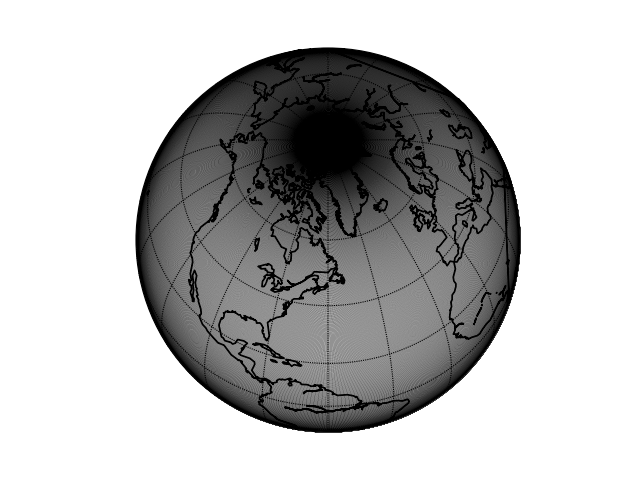

In [58]:
from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib.pyplot as plt
import numpy as np

m = Basemap(resolution='c',projection='ortho',lat_0=60.,lon_0=-60.)

x,y=m(lon,lat)

m.plot(x,y,'ko', markersize=.01)

# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)



m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)


plt.show()

A faster? way of getting the data since we know that the first 3 messages are what we need is by using the gribapi from ECMWF

In [59]:
from gribapi import *

f=open(infile)
dat={} # create a dictionary 
for l in range(3): # loop for the first 3 messages
    gid=grib_new_from_file(f)
    if gid is None: break

    name=grib_get(gid, 'shortName')
    print name
    dat[name]=grib_get_values(gid)
    
    grib_release(gid)
    
f.close()

msl
10u
10v


In [60]:
dat

{'10u': array([-4.41326904, -4.41619873, -4.42010498, ..., -1.22967529,
        -1.22283936, -1.21600342]),
 '10v': array([-3.49900818, -3.4931488 , -3.48728943, ..., -5.84764099,
        -5.85057068, -5.85350037]),
 'msl': array([ 101665.25,  101665.25,  101665.25, ...,  101335.5 ,  101335.5 ,
         101335.5 ])}

In [61]:
dat['msl'].shape

(13107200,)

We see above that the data are given in 1-D array. This applies for the lat, lon variables. However we can 'expand' them using some functions from the pygrib module. First the redtoreg function which translates from reduced_gg to regular_gg
NOTE: This function uses cimport and has to be saved in .pyx extension. It doesn't compile within the notebook.

Create a function as above for reading a message

In [4]:
from gribapi import *

def getd(infile):
    f=open(infile)
    dat={} # create a dictionary 
    for l in range(3): # loop for the first 3 messages
        gid = grib_new_from_file(f)#,headers_only = True)
        if gid is None:
            print 'time = {}, gid = None'.format(t)
            sys.exit(1)

        name=grib_get(gid, 'shortName')
        mv=grib_get(gid,'missingValue')

        lonfgp=grib_get(gid,'longitudeOfFirstGridPointInDegrees')
        latfgp=grib_get(gid,'latitudeOfFirstGridPointInDegrees')
        lonlgp=grib_get(gid,'longitudeOfLastGridPointInDegrees')
        latlgp=grib_get(gid,'latitudeOfLastGridPointInDegrees')

        if grib_get(gid,'gridType') == 'regular_gg':

          Ni=grib_get(gid,'Ni')
          Nj=grib_get(gid,'Nj')
          lat=grib_get_array(gid,'latitudes')
          lat=lat.reshape(Nj,Ni)
        #  lat=np.flipud(lat)
          lon=grib_get_array(gid,'longitudes')
          lon=lon.reshape(Nj,Ni)

          values=grib_get_values(gid)
          dat[name]=values.reshape(Nj,Ni)

        elif grib_get(gid,'gridType') == 'reduced_gg' :

          ss=grib_get_array(gid,'pl')  # lons per lat for the reduced_gg grid
          lon,lat = gridd(lonfgp,latfgp,lonlgp,latlgp,ss.size)

          values=grib_get_values(gid)
          ny=2*np.size(ss)

          dat[name]=_redtoreg(ny,ss,values,mv)

        grib_release(gid)
     
    f.close()

    return dat,lat,lon



this uses the function gridd for 'expanding' the lat,lon grid to regular_gg

In [5]:
import numpy as np
def gridd(lon1,lat1,lon2,lat2,nlats):

        #   lon1, lat1 = self.longitude_first_gridpoint, self.latitude_first_gridpoint
        #   lon2, lat2 = self.longitude_last_gridpoint, self.latitude_last_gridpoint
        #   nlats = self.points_in_y_direction
            # ECMWF 'reduced' gaussian grid.
            nlons = 2*nlats
            delon = 360./nlons
        #   lons = np.arange(lon1,lon2,delon)
            lons = np.linspace(lon1,lon2,nlons)
            # compute gaussian lats (north to south)
            lats = gaulats(nlats)
          #  if lat1 > lat2 :  # ATTENTION
          #     lats = lats[::-1]
          # lons = lons[::-1]
            lons,lats = np.meshgrid(lons,lats) # make 2-d arrays

            return lons,lats




Now we can get the data, lat, lon as

In [6]:
import pyximport
pyximport.install()

from redtoreg import _redtoreg
from pygrib import gaulats

gdat,glat,glon=getd(infile)


In [18]:
gdat

{'10u': array([[ 2.21650696,  2.22006226,  2.22361755, ...,  2.20292282,
          2.20745087,  2.21197891],
        [ 2.31611633,  2.31976013,  2.32340393, ...,  2.30232849,
          2.30692444,  2.31152039],
        [ 2.46260071,  2.46596527,  2.46932983, ...,  2.44951096,
          2.45387421,  2.45823746],
        ..., 
        [ 1.15498352,  1.16422272,  1.17346191, ...,  1.13003769,
          1.13835297,  1.14666824],
        [ 1.64912415,  1.65800018,  1.66687622, ...,  1.62303162,
          1.63172913,  1.64042664],
        [ 2.00263977,  2.01062393,  2.01860809, ...,  1.97713089,
          1.98563385,  1.99413681]]),
 '10v': array([[ 3.06031799,  3.05681229,  3.05330658, ...,  3.06695557,
          3.06474304,  3.06253052],
        [ 2.82984924,  2.82621002,  2.8225708 , ...,  2.83773193,
          2.83510437,  2.83247681],
        [ 2.71266174,  2.70907822,  2.70549469, ...,  2.72177811,
          2.71873932,  2.71570053],
        ..., 
        [-7.08909607, -7.08744049, -7.

We can compare the data with the ones above

In [84]:
np.array_equal(dat['msl'],gdat['msl'].ravel())

True

In [85]:
np.array_equal(dat['10u'],gdat['10u'].ravel())

True

In [86]:
np.array_equal(dat['10v'],gdat['10v'].ravel())

True

In [87]:
np.array_equal(lat,glat.ravel())

True

In [88]:
np.array_equal(lon,glon.ravel())

True

In terms of speed ......

In [89]:
import pygrib

def getd0(infile):

    dat={}
    data=pygrib.open(infile)
    for i in range(1,4):
        var=data[i]
        name=var['shortName']
        dat[name]=var.values
        
        lat,lon=var.latlons()
    
    return dat,lon,lat
    

In [90]:
%timeit d1,lo1,la1=getd0(infile)

1 loop, best of 3: 8min 52s per loop


In [91]:
%timeit d2,lo2,la2=getd(infile)

1 loop, best of 3: 4.3 s per loop


#### One could add here the command tool cdo for comparison